In [59]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [60]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [61]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [62]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [63]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
10112,1698076800,1.06094,1.06128,1.05984,1.06004,3837,9,0
10113,1698078600,1.06004,1.06056,1.05907,1.06048,5901,9,0
10114,1698080400,1.06049,1.06316,1.06044,1.06260,6956,9,0
10115,1698082200,1.06260,1.06299,1.06173,1.06283,6257,9,0


In [64]:


def rsi(df, lookback=21):
    df['rsi'] = ta.rsi(close=df['close'], length=lookback)
    return df

def calculateSuperTrendIndicator(df, multiplier = 2, atrLookup = 10):
    supertrend= ta.supertrend(df['high'], df['low'], df['close'], length=atrLookup, multiplier=multiplier)
    df['supertrend'] = supertrend[f'SUPERT_{atrLookup}_{float(multiplier)}']
    return df





In [65]:

multiplier=2
atrLookup=20
rsilookback=50
rsithreshold=50

df = rsi(df, rsilookback)
df = calculateSuperTrendIndicator(df, multiplier, atrLookup)

df = df.dropna()

df



,time,open,high,low,close,tick_volume,spread,real_volume,rsi,supertrend
50,1672707600,1.06643,1.06832,1.06497,1.06637,6050,7,0,41.724403,1.067064
51,1672709400,1.06637,1.06771,1.06633,1.06762,4286,7,0,47.896648,1.064930
52,1672711200,1.06762,1.06779,1.06665,1.06684,3472,7,0,44.870594,1.065120
53,1672713000,1.06684,1.06747,1.06677,1.06703,2445,7,0,45.722949,1.065120
54,1672714800,1.06703,1.06740,1.06547,1.06558,7146,7,0,40.809494,1.065120
...,...,...,...,...,...,...,...,...,...,...
10112,1698076800,1.06094,1.06128,1.05984,1.06004,3837,9,0,53.919398,1.059274
10113,1698078600,1.06004,1.06056,1.05907,1.06048,5901,9,0,54.801015,1.059274
10114,1698080400,1.06049,1.06316,1.06044,1.06260,6956,9,0,58.687037,1.059614
10115,1698082200,1.06260,1.06299,1.06173,1.06283,6257,9,0,59.076544,1.060157


In [66]:

buyIndices=[]
sellIndices=[]

buys=[]
sells=[]

position = None

sl = 0.5 / 100
tp = 2.0 / 100

slamount = None
tpamount = None


for i in range(len(df)):
    if (i > 0) and (position is None) and (df.iloc[i]['close'] > df.iloc[i]['supertrend']) and (df.iloc[i - 1]['close'] < df.iloc[i - 1]['supertrend']) and (df.iloc[i]['rsi'] > rsithreshold):
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
        slamount = df.iloc[i]['close'] - (sl * df.iloc[i]['close'])
        tpamount = df.iloc[i]['close'] + (tp * df.iloc[i]['close'])
    if (i > 0) and (position == 'long') and (
        (
            (df.iloc[i]['close'] < df.iloc[i]['supertrend']) and
            (df.iloc[i - 1]['close'] > df.iloc[i - 1]['supertrend']) and
            (df.iloc[i]['rsi'] < rsithreshold)
        ) or (
            (df.iloc[i]['close'] <= slamount)
        ) or (
            (df.iloc[i]['close'] >= tpamount)
        )
    ):
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None
        slamount = None
        tpamount = None




In [67]:

print(buys)
print(sells)

print(buyIndices)
print(sellIndices)


[1.07181, 1.08438, 1.08111, 1.08284, 1.08901, 1.08784, 1.07403, 1.06738, 1.06064, 1.06243, 1.06213, 1.06707, 1.09028, 1.08429, 1.09132, 1.09164, 1.09733, 1.09708, 1.09772, 1.09632, 1.09898, 1.10129, 1.10664, 1.10391, 1.10475, 1.10003, 1.09923, 1.08881, 1.08124, 1.08279, 1.07175, 1.07159, 1.09272, 1.0925799999999999, 1.09174, 1.09143, 1.08938, 1.08879, 1.0892, 1.1155, 1.1103399999999999, 1.10251, 1.09887, 1.0985800000000001, 1.09983, 1.10015, 1.09267, 1.08893, 1.09013, 1.08178, 1.08636, 1.07141, 1.06747, 1.06602, 1.05624, 1.05198, 1.05331, 1.05497]
[1.081, 1.0782, 1.08033, 1.08752, 1.08664, 1.0822, 1.0719, 1.06558, 1.05972, 1.05669, 1.05562, 1.08916, 1.08414, 1.08918, 1.09144, 1.09767, 1.09663, 1.09438, 1.09538, 1.09552, 1.10166, 1.09849, 1.10352, 1.10245, 1.10251, 1.09649, 1.09759, 1.08797, 1.08054, 1.0806, 1.0712, 1.09323, 1.09129, 1.0868, 1.09399, 1.08978, 1.08733, 1.08756, 1.112, 1.11887, 1.10243, 1.10179, 1.0966, 1.0984, 1.09818, 1.09679, 1.09129, 1.08714, 1.08434, 1.08328, 1.08153

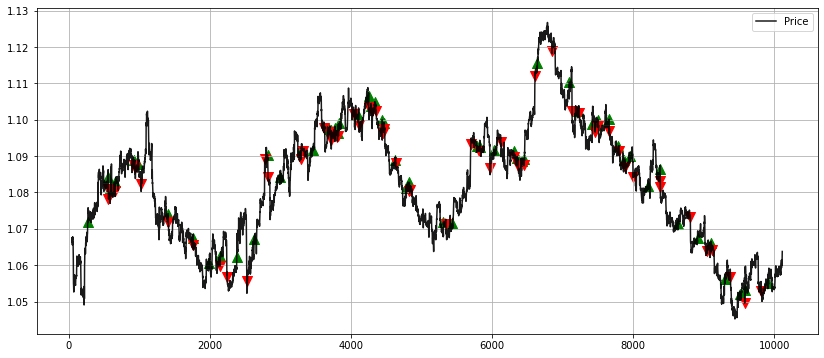

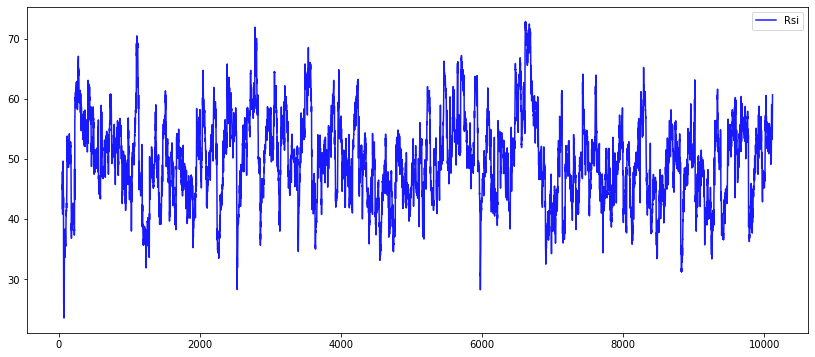

In [68]:


plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (14, 6))
plt.plot(df['rsi'], label='Rsi', c='blue', alpha=0.9)
plt.legend()
plt.show()



In [69]:




brokerage = 1 / 100

wins = 0
losses = 0

profit = 0
loss = 0

averageprofit = 0
averageloss = 0

netresult = ''

for i in range(len(sells)):
    maximum = max(sells[i], buys[i])
    brokerageAmount = brokerage * maximum
    diff = sells[i] - buys[i] - brokerageAmount
    if (diff > 0):
        wins += 1
        profit += diff
    if (diff < 0):
        losses += 1
        loss += abs(diff)

if (profit > loss):
    netresult = 'Win'
elif (profit == loss):
    netresult = 'None'
else:
    netresult = 'Loss'

if profit and wins:
    averageprofit = profit / wins

if loss and losses:
    averageloss = loss / losses

hitratio = (wins / (wins + losses)) * 100
profitfactor = (profit / loss)
expectancy = (averageprofit * hitratio) - (averageloss * (1 - hitratio))
riskreward = (averageprofit / averageloss)

print(f'''
    Net result = {netresult}
    Hit ratio = {hitratio} %
    Profit factor = {profitfactor} {{currency}}
    Expectancy = {expectancy} {{currency}}
    Realised risk reward ratio = {riskreward} {{currency}}
''')







    Net result = Loss
    Hit ratio = 5.263157894736842 %
    Profit factor = 0.05055880058612276 {currency}
    Expectancy = 0.11136754561403492 {currency}
    Realised risk reward ratio = 0.9100584105502096 {currency}

